### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Sat Mar 22 19:25:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

In [3]:
!pip install -q rfdetr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 18.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.0/122.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

## Inference with Pre-trained COCO Model

Loading pretrain weights


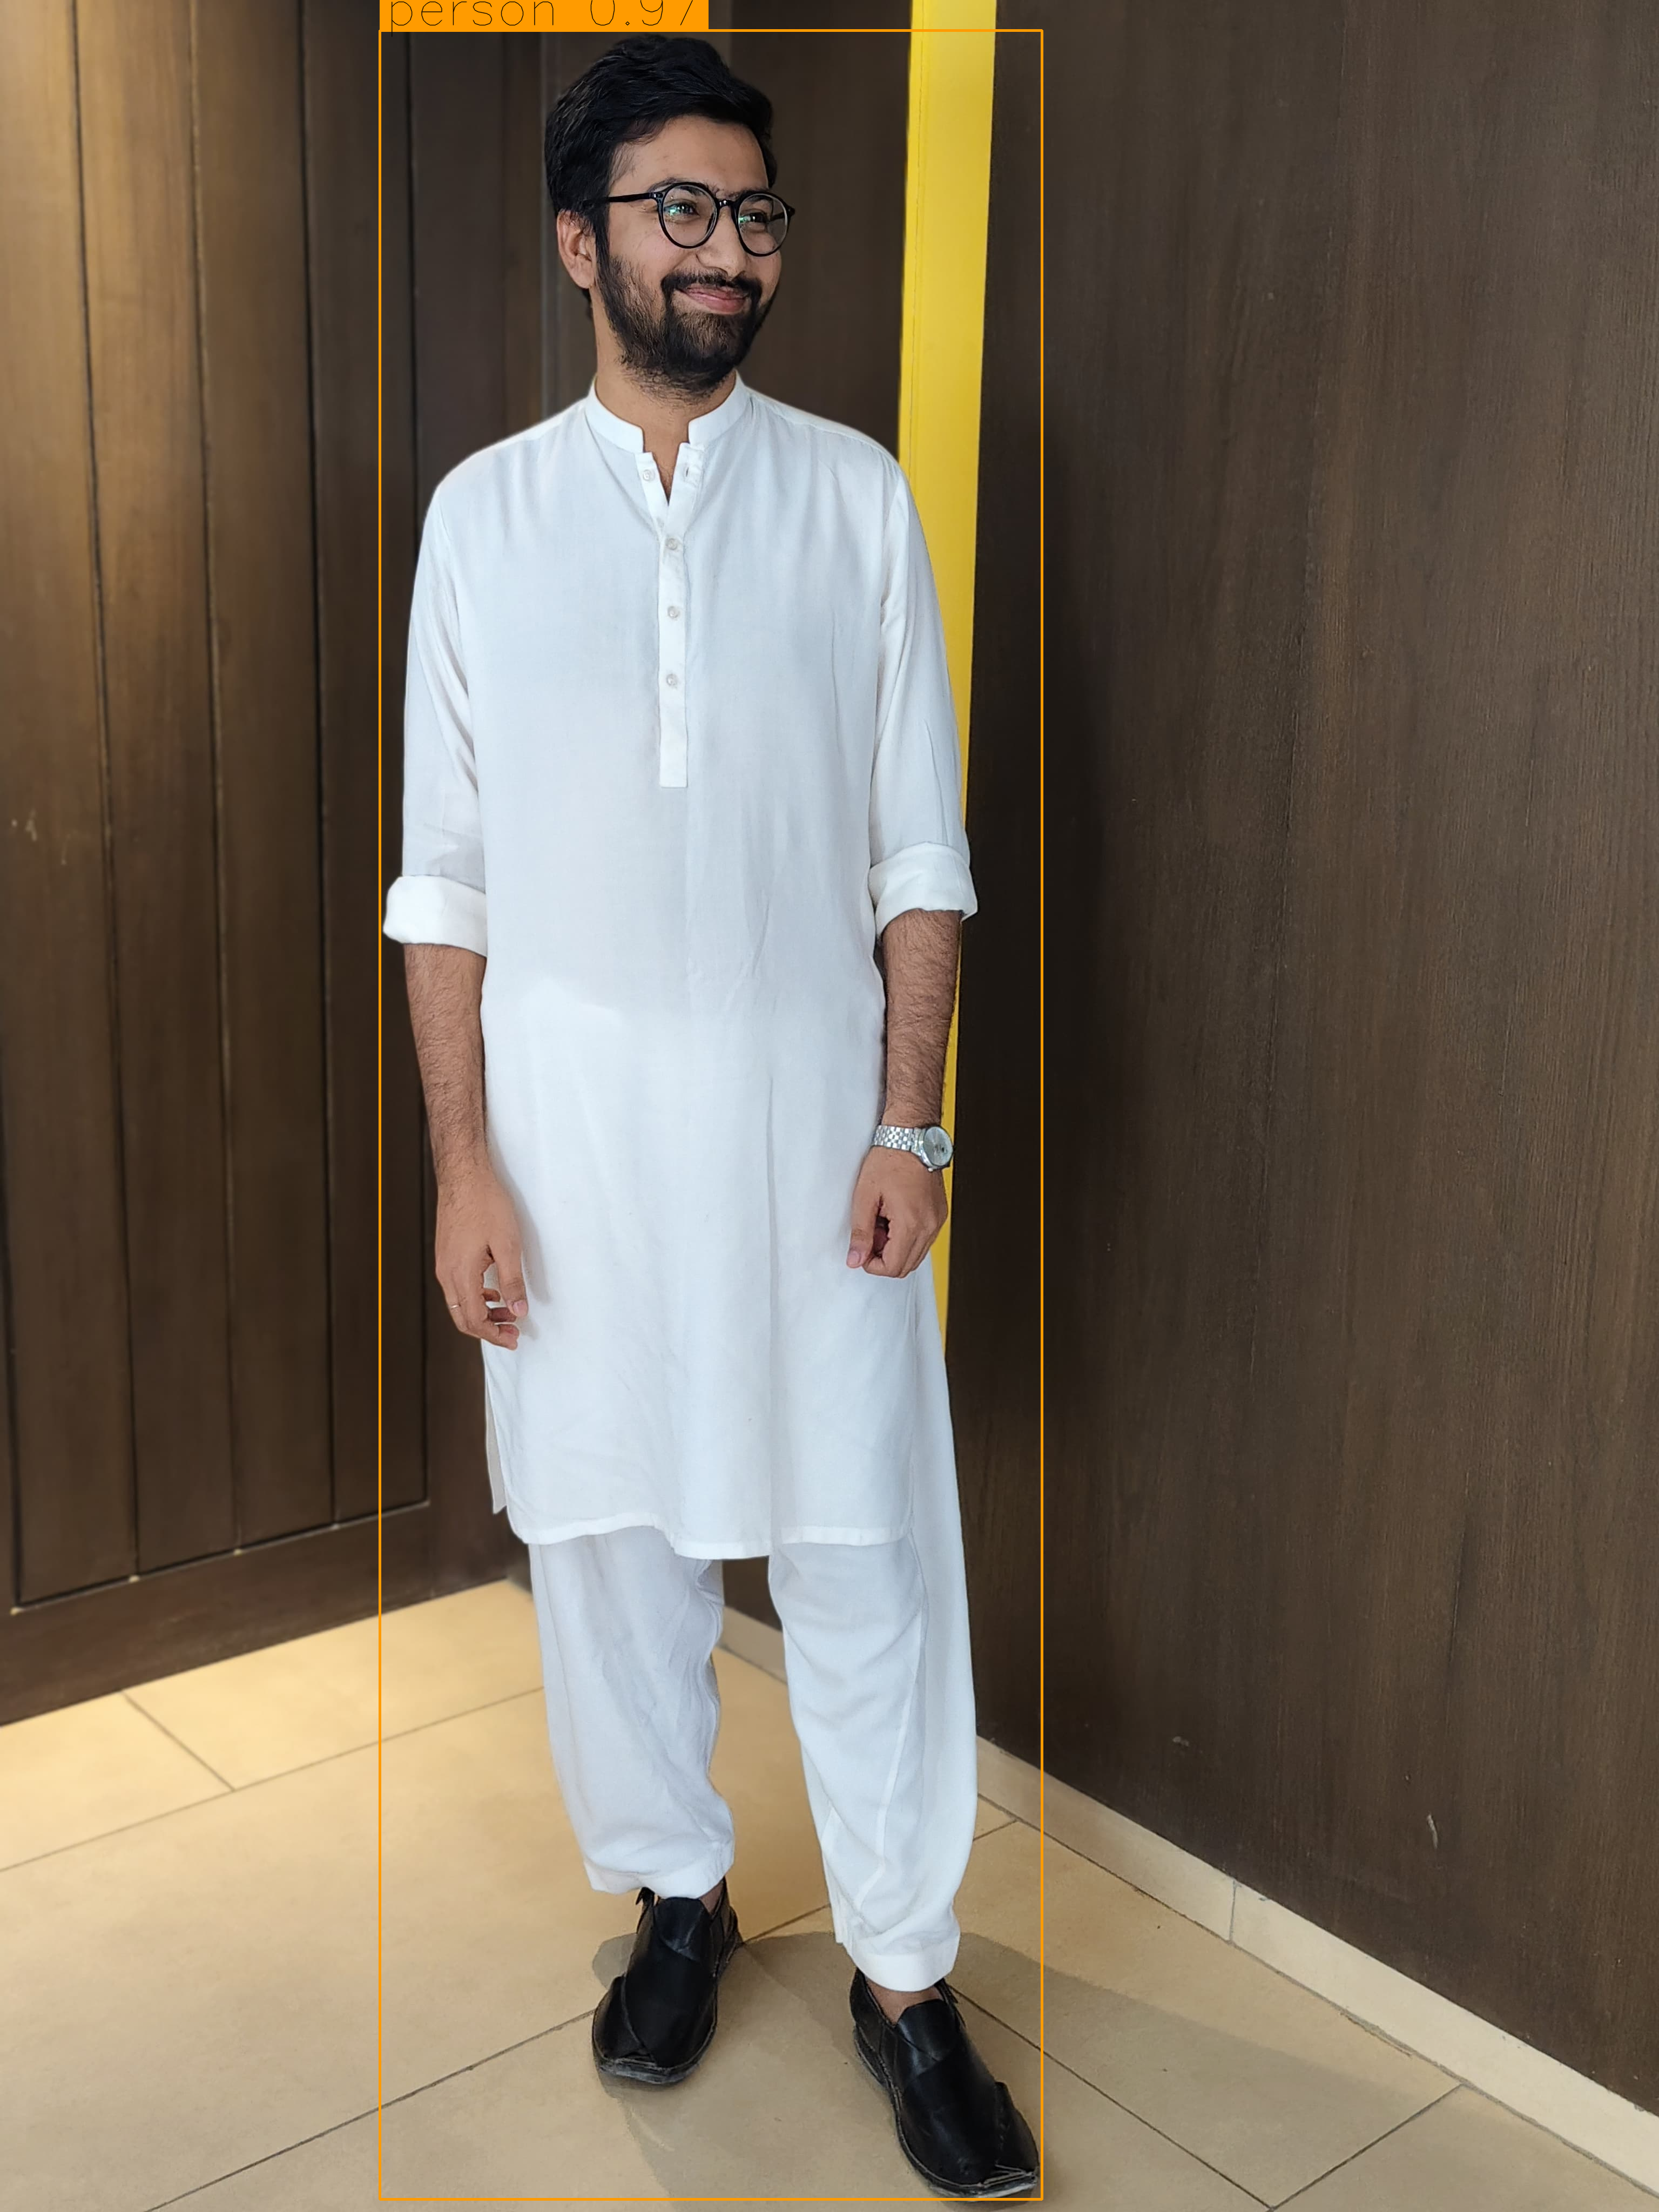

In [10]:
from rfdetr import RFDETRBase
from rfdetr.util.coco_classes import COCO_CLASSES
import supervision as sv
import numpy as np
from PIL import Image

image = Image.open("demo.jpg")

model = RFDETRBase()
detections = model.predict(image, threshold=0.5)

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    smart_position=True
)

labels = [
    f"{COCO_CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = bbox_annotator.annotate(annotated_image, detections)
annotated_image = label_annotator.annotate(annotated_image, detections, labels)
annotated_image

## Download dataset from Roboflow Universe

In [8]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="mgDbHMdsllImLwB8BNVN")
project = rf.workspace("rf100-vl").project("mahjong-vtacs-mexax-m4vyu-sjtd")
version = project.version(2)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to mahjong-vtacs-mexax-m4vyu-sjtd-2 in coco:: 100%|██████████| 2143/2143 [00:10<00:00, 210.46it/s]


## Train RF-DETR on custom dataset

In [9]:
from rfdetr import RFDETRBase

model = RFDETRBase()
history = []

def callback2(data):
    history.append(data)

model.callbacks["on_fit_epoch_end"].append(callback2)

model.train(dataset_dir=dataset.location, epochs=5, batch_size=4, grad_accum_steps=1, lr=1e-4)

Loading pretrain weights


reinitializing your detection head with 35 classes.


Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=35, grad_accum_steps=1, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=5, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-base.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[2, 5, 8, 11], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=3, dim_feedforward=2048, hidden_dim=256, sa_nheads=8, ca_nheads=16, num_queries=300, group_detr=13, two_stage=True, projector_scale=['P4'], lite_refpoint_refine=True, num_select=300, dec_n_poin

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch: [0]  [  0/373]  eta: 0:27:05  lr: 0.000100  class_error: 97.44  loss: 15.6990 (15.6990)  loss_ce: 0.9006 (0.9006)  loss_bbox: 1.6259 (1.6259)  loss_giou: 1.1800 (1.1800)  loss_ce_0: 0.7970 (0.7970)  loss_bbox_0: 1.9398 (1.9398)  loss_giou_0: 1.3405 (1.3405)  loss_ce_1: 0.8976 (0.8976)  loss_bbox_1: 1.6316 (1.6316)  loss_giou_1: 1.1862 (1.1862)  loss_ce_enc: 0.8187 (0.8187)  loss_bbox_enc: 2.0225 (2.0225)  loss_giou_enc: 1.3586 (1.3586)  loss_ce_unscaled: 0.9006 (0.9006)  class_error_unscaled: 97.4359 (97.4359)  loss_bbox_unscaled: 0.3252 (0.3252)  loss_giou_unscaled: 0.5900 (0.5900)  cardinality_error_unscaled: 3898.5000 (3898.5000)  loss_ce_0_unscaled: 0.7970 (0.7970)  loss_bbox_0_unscaled: 0.3880 (0.3880)  loss_giou_0_unscaled: 0.6703 (0.6703)  cardinality_error_0_unscaled: 3897.7500 (3897.7500)  loss_ce_1_unscaled: 0.8976 (0.8976)  loss_bbox_1_unscaled: 0.3263 (0.3263)  loss_giou_1_unscaled: 0.5931 (0.5931)  cardinality_error_1_unscaled: 3898.5000 (3898.5000)  loss_ce_enc_uns

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Test:  [  0/107]  eta: 0:03:23  class_error: 34.29  loss: 5.7444 (5.7444)  loss_ce: 0.8711 (0.8711)  loss_bbox: 0.1366 (0.1366)  loss_giou: 0.3247 (0.3247)  loss_ce_0: 1.0547 (1.0547)  loss_bbox_0: 0.1300 (0.1300)  loss_giou_0: 0.2995 (0.2995)  loss_ce_1: 0.9297 (0.9297)  loss_bbox_1: 0.1340 (0.1340)  loss_giou_1: 0.3148 (0.3148)  loss_ce_enc: 1.1719 (1.1719)  loss_bbox_enc: 0.1086 (0.1086)  loss_giou_enc: 0.2689 (0.2689)  loss_ce_unscaled: 0.8711 (0.8711)  class_error_unscaled: 34.2857 (34.2857)  loss_bbox_unscaled: 0.0273 (0.0273)  loss_giou_unscaled: 0.1623 (0.1623)  cardinality_error_unscaled: 290.5000 (290.5000)  loss_ce_0_unscaled: 1.0547 (1.0547)  loss_bbox_0_unscaled: 0.0260 (0.0260)  loss_giou_0_unscaled: 0.1498 (0.1498)  cardinality_error_0_unscaled: 290.0000 (290.0000)  loss_ce_1_unscaled: 0.9297 (0.9297)  loss_bbox_1_unscaled: 0.0268 (0.0268)  loss_giou_1_unscaled: 0.1574 (0.1574)  cardinality_error_1_unscaled: 290.7500 (290.7500)  loss_ce_enc_unscaled: 1.1719 (1.1719)  los

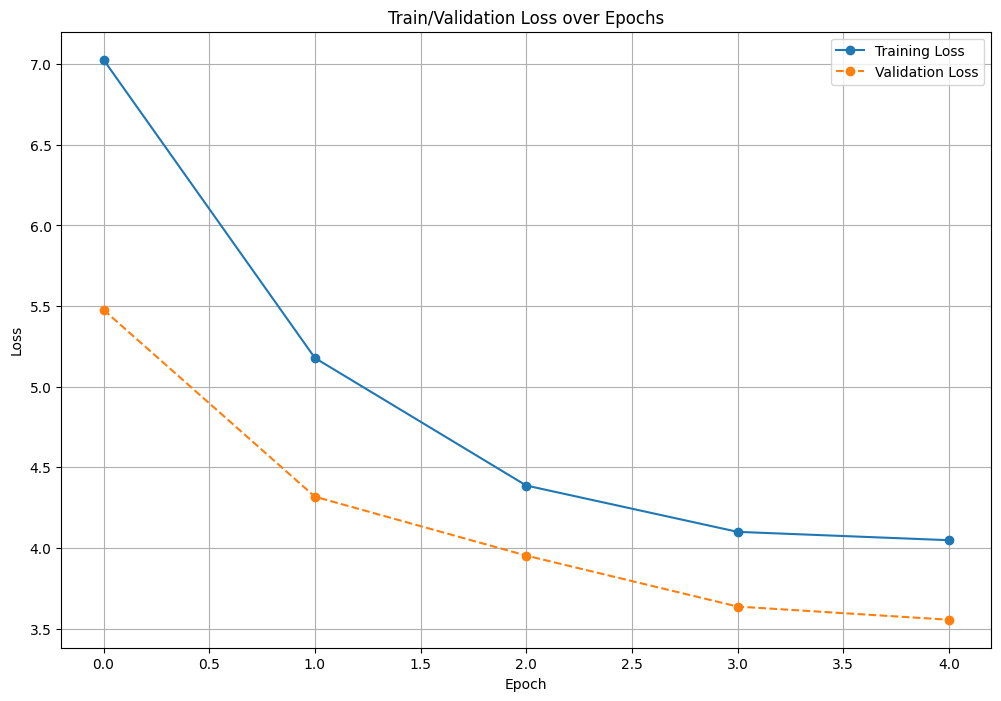

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(history)

plt.figure(figsize=(12, 8))

plt.plot(
    df['epoch'],
    df['train_loss'],
    label='Training Loss',
    marker='o',
    linestyle='-'
)

plt.plot(
    df['epoch'],
    df['test_loss'],
    label='Validation Loss',
    marker='o',
    linestyle='--'
)

plt.title('Train/Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

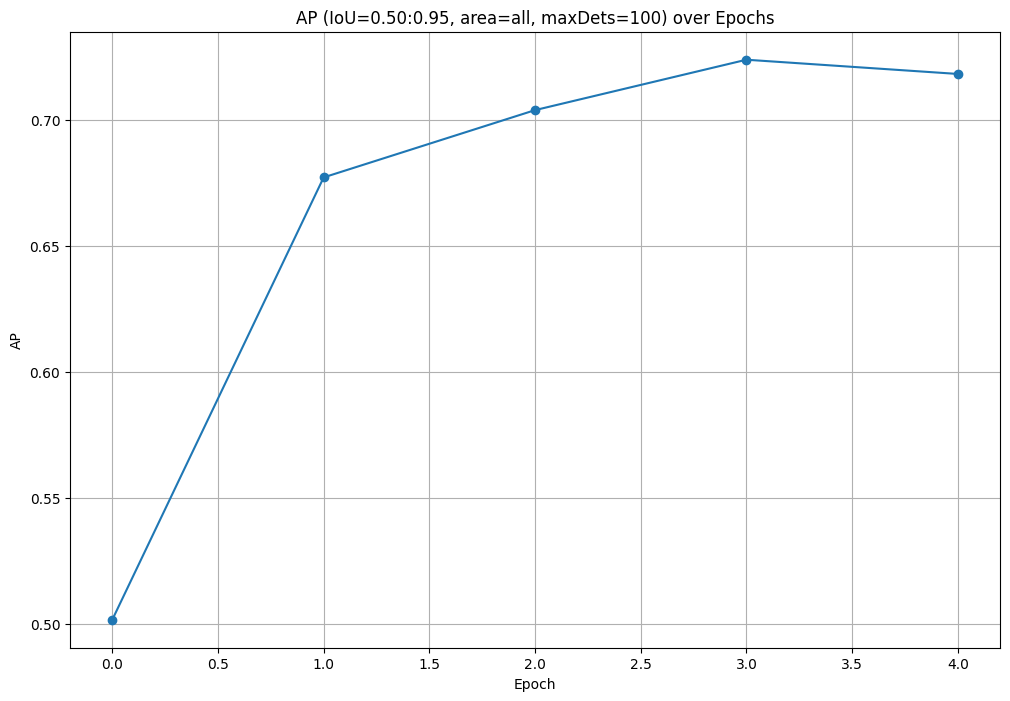

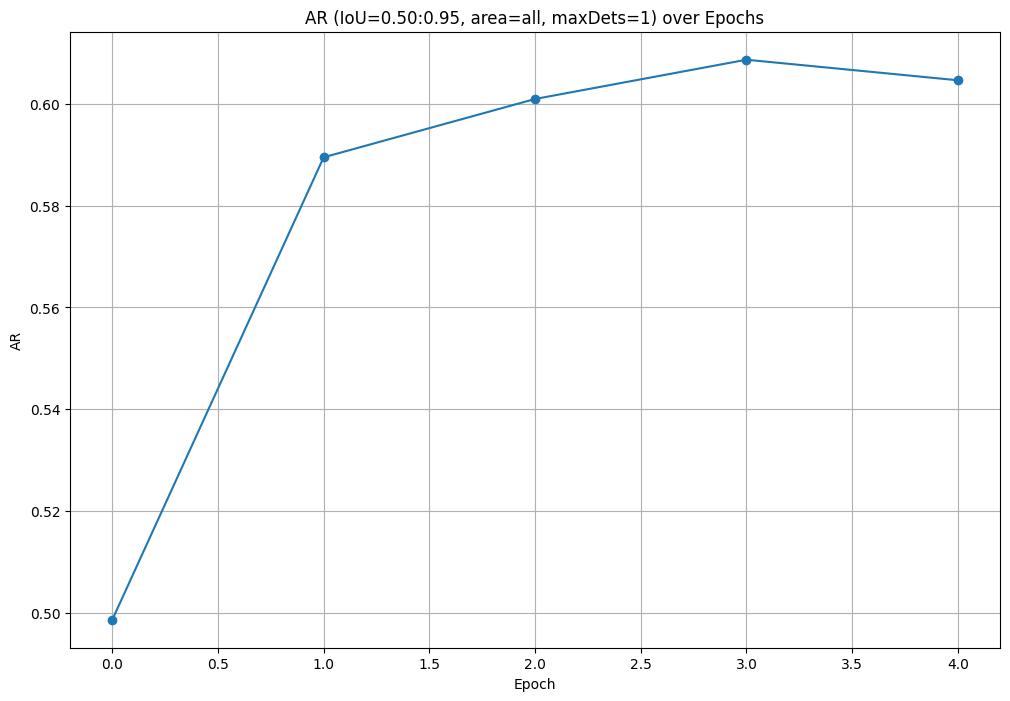

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(history)

df['avg_precision'] = df['test_coco_eval_bbox'].apply(lambda arr: arr[0])
df['avg_recall'] = df['test_coco_eval_bbox'].apply(lambda arr: arr[6])

plt.figure(figsize=(12, 8))
plt.plot(
    df['epoch'],
    df['avg_precision'],
    marker='o',
    linestyle='-'
)
plt.title('AP (IoU=0.50:0.95, area=all, maxDets=100) over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AP')
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 8))
plt.plot(
    df['epoch'],
    df['avg_recall'],
    marker='o',
    linestyle='-'
)
plt.title('AR (IoU=0.50:0.95, area=all, maxDets=1) over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AR')
plt.grid(True)
plt.show()

## Run inference with fine-tuned model

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

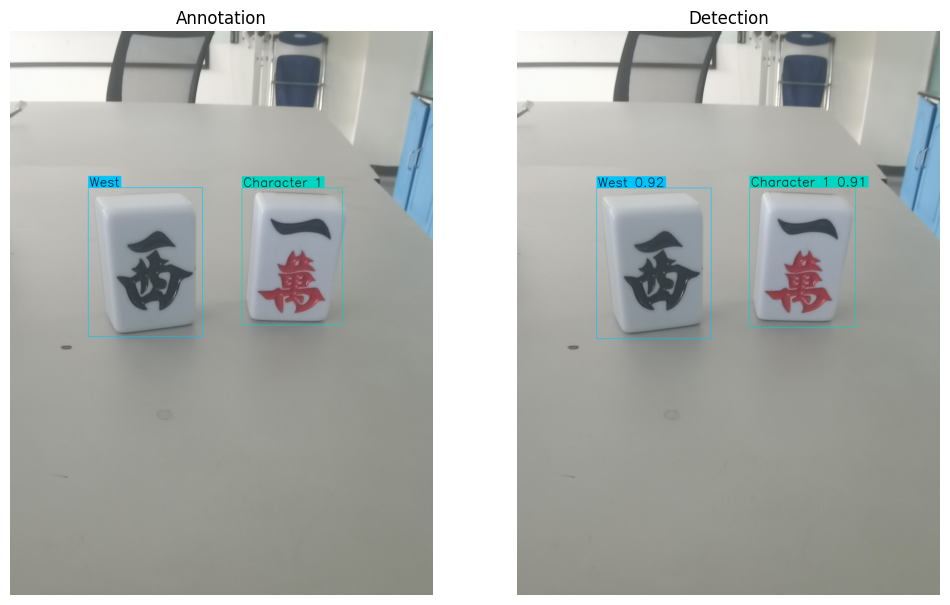

In [ ]:
from rfdetr import RFDETRBase
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    text_thickness=thickness,
    smart_position=True)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

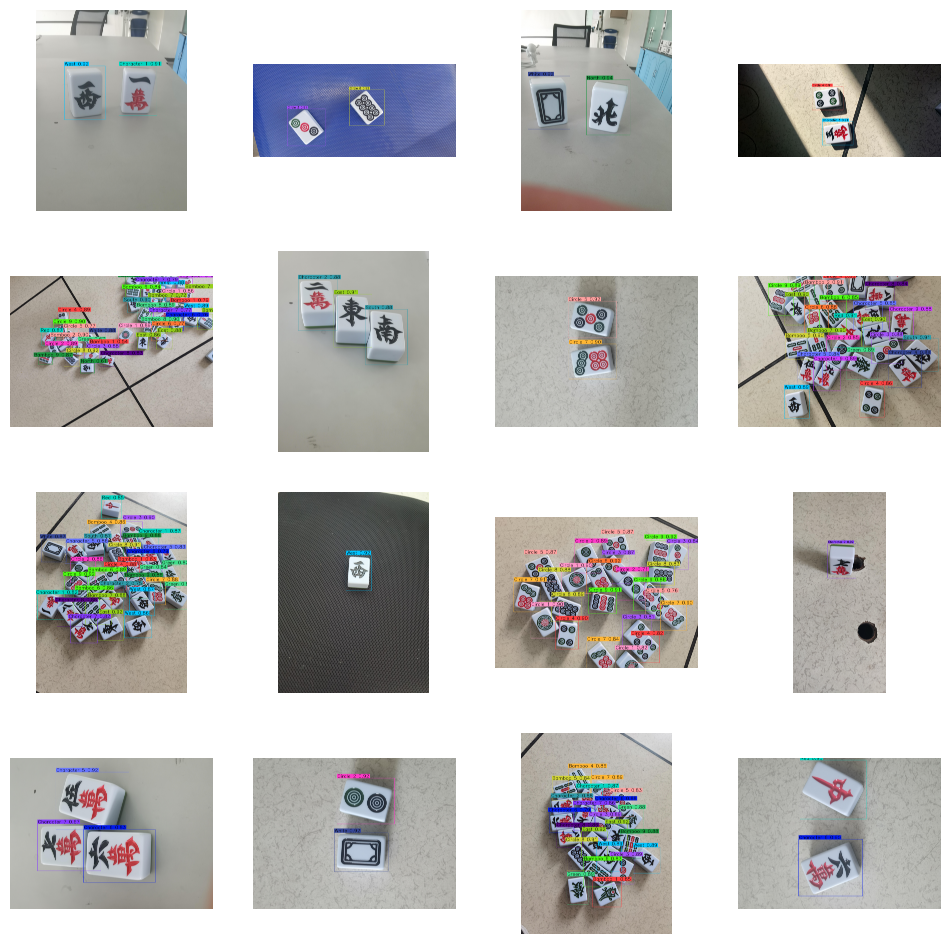

In [ ]:
import supervision as sv
from rfdetr import RFDETRBase
from PIL import Image

detections_images = []

for i in range(16):
    path, image, annotations = ds[i]
    image = Image.open(path)

    detections = model.predict(image, threshold=0.5)

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

    bbox_annotator = sv.BoxAnnotator(thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        text_thickness=thickness,
        smart_position=True)

    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    detections_image = image.copy()
    detections_image = bbox_annotator.annotate(detections_image, detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

    detections_images.append(detections_image)

sv.plot_images_grid(images=detections_images, grid_size=(4, 4))

## Evaluate fine-tuned model

In [ ]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0.5)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 214/214 [00:56<00:00,  3.81it/s]


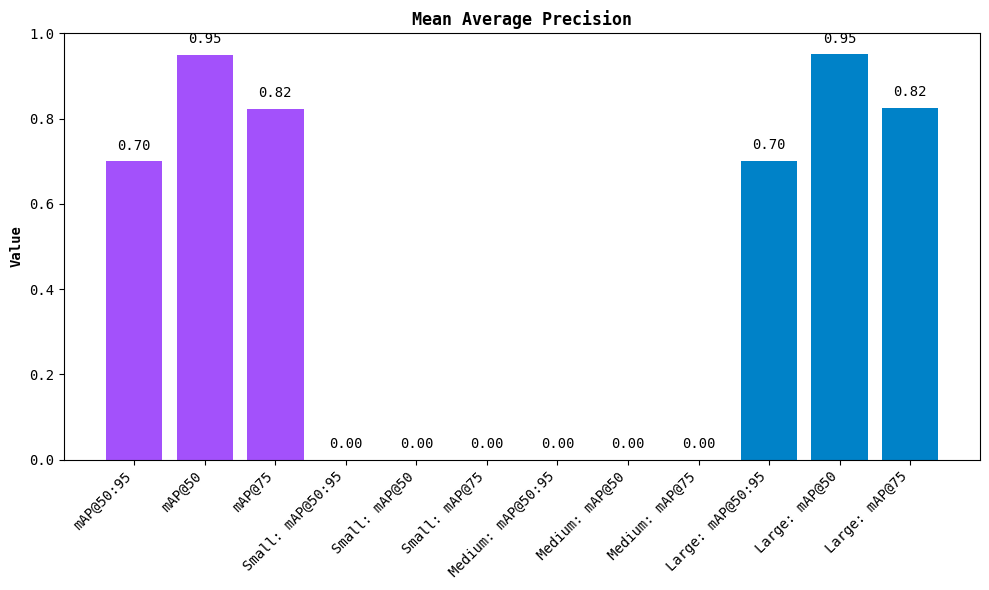

In [ ]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()

map_result.plot()

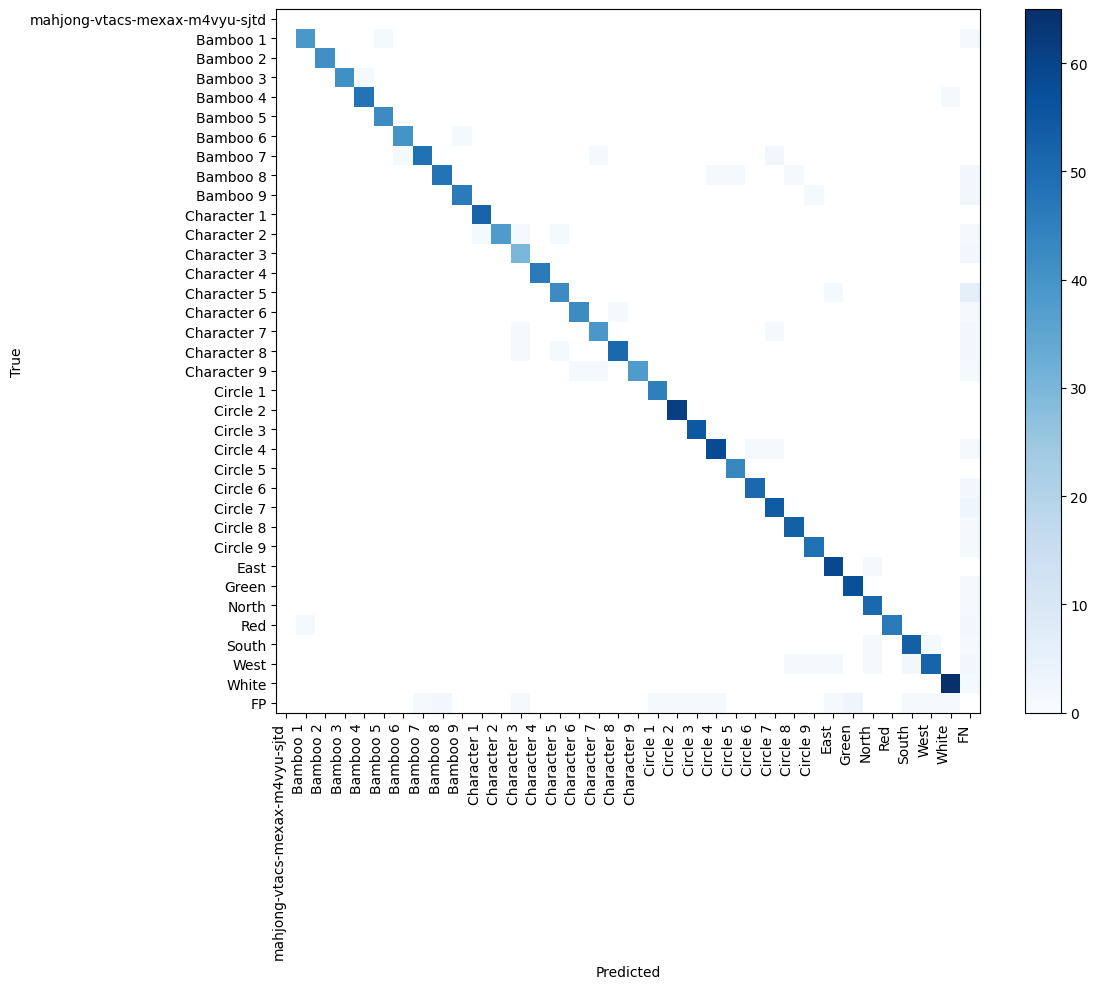

In [ ]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds.classes
)

_ = confusion_matrix.plot()